In [2]:
# Install necessary libraries
!pip install mysql-connector-python pandas matplotlib seaborn

In [63]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
# Convert Excel to CSV
df = pd.read_excel("C:/Users/kumar/Downloads/E-Commerce Sale Report Dumy.xlsx")
df.to_csv("C:/Users/kumar/Downloads/E-Commerce Sale Report Dumy.csv", index=False)

# MySQL connection details
try:
    conn = mysql.connector.connect(
        host='localhost',
    user='root',
    password='Aniljha@2802',
    database='edhc_ecommerce'
    )
    print("Connected to MySQL database")

    # Load entire dataset for fallback or additional processing
    query_all = "SELECT * FROM `E-Commerce Sale Report Dumy`"
    df = pd.read_sql(query_all, conn)
    print(df.head())
except mysql.connector.Error as err:
    print(f"Error connecting to MySQL: {err}")
    # Fallback: Load from CSV
    df = pd.read_csv("C:/Users/kumar/Downloads/E-Commerce Sale Report Dumy.csv")


Connected to MySQL database
        Date Month  Year Channel Name  \
0  18-May-23   May  2023    TATA CLIQ   
1  21-May-23   May  2023    TATA CLIQ   
2  27-May-23   May  2023    TATA CLIQ   
3  30-May-23   May  2023    TATA CLIQ   
4  30-May-23   May  2023    TATA CLIQ   

                        Site Name[Short Name]  Type Ordering Channel  \
0  MONT BLANC VENTURES PRIVATE LIMITED [ELDS]  Sale        TATA CLIQ   
1  MONT BLANC VENTURES PRIVATE LIMITED [ELDS]  Sale        TATA CLIQ   
2  MONT BLANC VENTURES PRIVATE LIMITED [ELDS]  Sale        TATA CLIQ   
3  MONT BLANC VENTURES PRIVATE LIMITED [ELDS]  Sale        TATA CLIQ   
4  MONT BLANC VENTURES PRIVATE LIMITED [ELDS]  Sale        TATA CLIQ   

  Courier Partner  Remarks Item Code  ...  Shipment Charge Amount IGST Rate  \
0    ECOM Express  Prepaid    MB1019  ...                       0        12   
1    ECOM Express  Prepaid    MB1087  ...                       0        12   
2    ECOM Express  Prepaid    MB1060  ...              

C:\Users\kumar\AppData\Local\Temp\ipykernel_14136\3220385428.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query_all, conn)


In [87]:
# Data Cleaning
# Convert Date to datetime (if not already)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# Extract year and month for grouping
df['year_month'] = df['Date'].dt.to_period('M')
# Replace empty or invalid values with None
df = df.replace('', None)
# Drop rows with missing critical values
df = df.dropna(subset=['NET Amount', 'Qty'])
# Convert numeric columns
numeric_cols = ['Qty', 'RSP', 'Rate', 'Gross Amount', 'Taxable Amount', 'Discount',
                'Extratax', 'Gift Wrap Amount', 'COD Charge Amount', 'Shipment Charge Amount',
                'IGST Rate', 'IGST Amount', 'SGST Rate', 'SGST Amount', 'CGST Rate',
                'CGST Amount', 'CESS Rate', 'CESS Amount', 'NET Amount']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# Calculate discount percentage
df['discount_percentage'] = (df['Discount'] / df['Gross Amount'] * 100).where(df['Gross Amount'] != 0, 0)
# Filter out returns for sales-specific analyses
df_sales = df[df['Type'] == 'Sale']

In [89]:
print(df.columns.tolist())

['Date', 'Month', 'Year', 'Channel Name', 'Site Name[Short Name]', 'Type', 'Ordering Channel', 'Courier Partner', 'Remarks', 'Item Code', 'Barcode', 'Brand', 'Product', 'CATEGORY', 'Item Name', 'RSP', 'Rate', 'Qty', 'Gross Amount', 'Taxable Amount', 'Discount', 'Extratax', 'Gift Wrap Amount', 'COD Charge Amount', 'Shipment Charge Amount', 'IGST Rate', 'IGST Amount', 'SGST Rate', 'SGST Amount', 'CGST Rate', 'CGST Amount', 'CESS Rate', 'CESS Amount', 'NET Amount', 'year_month', 'discount_percentage']


In [95]:
# Initialize dictionary to store query results
query_results = {}

# Assuming df is already loaded from CSV in a previous cell
# Create a copy of the sales DataFrame to avoid SettingWithCopyWarning
df_sales = df[df['Type'] == 'Sale'].copy()


# Query 1: Year and Brand-wise Sales (Sales only)
df_sales_brand_year = df_sales.groupby(['Year', 'Brand'])['NET Amount'].sum().reset_index()
query_results['year_brand_sales'] = df_sales_brand_year.sort_values(by=['Year', 'NET Amount'], ascending=[True, False])

# Query 2: Year, Item Name, and Brand-wise Sales (Sales only) - Top 10
df_sales_item_brand_year = df_sales.groupby(['Year', 'Item Name', 'Brand'])['NET Amount'].sum().reset_index()
query_results['year_item_brand_sales'] = df_sales_item_brand_year.sort_values(by=['Year', 'NET Amount'], ascending=[True, False]).head(10)

# Query 3: Department-wise Sales (using CATEGORY, Sales only)
df_sales_department = df_sales.groupby('CATEGORY')['NET Amount'].sum().reset_index()
query_results['department_sales'] = df_sales_department.sort_values(by='NET Amount', ascending=False)

# Query 4: Section-wise Sales (using product, Sales only)
df_sales_section = df_sales.groupby('Product')['NET Amount'].sum().reset_index()
query_results['section_sales'] = df_sales_section.sort_values(by='NET Amount', ascending=False)

# Query 5: Top Ordering Channel Year-wise (Sales only)
df_sales_channel_year = df_sales.groupby(['Year', 'Ordering Channel'])['NET Amount'].sum().reset_index()
query_results['top_channel_year'] = df_sales_channel_year.sort_values(by=['Year', 'NET Amount'], ascending=[True, False])

# Query 6: Monthly Sales Trend for Trend Analysis (Sales only)
# Ensure 'year_month' is sorted correctly for time series
df_sales_monthly = df_sales.groupby('year_month')['NET Amount'].sum().reset_index()
df_sales_monthly['year_month'] = df_sales_monthly['year_month'].astype(str) # Convert Period to string for display
query_results['monthly_sales'] = df_sales_monthly.sort_values(by='year_month')

# Query 7: Interesting Fact - Item with Highest Average Discount (Sales only)
# Calculate average discount percentage for each item in sales data
df_sales['discount_percentage'] = (df_sales['Discount'] / df_sales['Gross Amount'] * 100).where(df_sales['Gross Amount'] != 0, 0)
df_avg_discount_item = df_sales.groupby('Item Name')['discount_percentage'].mean().reset_index()
highest_discount_item_row = df_avg_discount_item.sort_values(by='discount_percentage', ascending=False).iloc[0]
interesting_fact = f"Interesting Fact: The item '{highest_discount_item_row['Item Name']}' has the highest average discount at {highest_discount_item_row['discount_percentage']:.2f}%."
query_results['highest_discount_item'] = highest_discount_item_row


# Query 8: Return Rate by Category
# Assuming 'Qty' is the column for quantity
df_returns = df[df['Type'] == 'Return']
df_sales_qty = df[df['Type'] == 'Sale']

return_qty_by_category = df_returns.groupby('CATEGORY')['Qty'].sum().reset_index(name='ReturnQty')
sales_qty_by_category = df_sales_Qtygroupby('CATEGORY')['Qty'].sum().reset_index(name='SalesQty')

return_rate_df = pd.merge(return_qty_by_category, sales_qty_by_category, on='CATEGORY', how='left').fillna(0)
return_rate_df['ReturnRate'] = (return_rate_df['ReturnQty'] / return_rate_df['SalesQty'] * 100).where(return_rate_df['SalesQty'] != 0, 0)
query_results['return_rate'] = return_rate_df.sort_values(by='ReturnRate', ascending=False)

# Query 9: COD vs Prepaid Sales Contribution (using Remarks)
# Assuming 'Remarks' column indicates payment type
df_payment_type = df_sales.groupby('Remarks')['NET Amount'].sum().reset_index()
query_results['payment_type'] = df_payment_type.sort_values(by='NET Amount', ascending=False)

# Display some of the results (optional)
print("Year and Brand-wise Sales:")
display(query_results['year_brand_sales'].head())

print("\nTop 10 Year, Item Name, and Brand-wise Sales:")
display(query_results['year_item_brand_sales'])

print("\nDepartment-wise Sales:")
display(query_results['department_sales'])

print("\nSection-wise Sales:")
display(query_results['section_sales'])

print("\nTop Ordering Channel Year-wise:")
display(query_results['top_channel_year'].head())

print("\nMonthly Sales Trend:")
display(query_results['monthly_sales'].head())

print("\nInteresting Fact:")
print(interesting_fact)

print("\nReturn Rate by Category:")
display(query_results['return_rate'].head())

print("\nCOD vs Prepaid Sales Contribution:")
display(query_results['payment_type'])

Year and Brand-wise Sales:


,Year,Brand,NET Amount
5,2023,Ralph Lauren,368730
0,2023,Diesel,348728
6,2023,Roberto Cavalli,256482
4,2023,Lacoste,206276
8,2023,Yves Delorme,144814



Top 10 Year, Item Name, and Brand-wise Sales:


,Year,Item Name,Brand,NET Amount
106,2023,TRIOMPHE Bed Cover Nacre,Yves Delorme,64999
25,2023,EAUX Bed Cover,Yves Delorme,57999
52,2023,L RENE Bathrobe Bitume,Lacoste,56097
98,2023,SHELL GARDEN Mug,Halcyon Days,51677
75,2023,PLAYER Bath Towel Charcoal,Ralph Lauren,44617
77,2023,PLAYER Bath Towel Stonewash,Ralph Lauren,43367
78,2023,PLAYER Bathrobe Marine,Ralph Lauren,38498
105,2023,TRAVIS Bathrobe Marine,Ralph Lauren,37798
102,2023,SNOW LEOPARD GOLD Guest Towel,Roberto Cavalli,31913
57,2023,LOFT Duvet Cover Carbon,Hugo Boss,30999



Department-wise Sales:


,CATEGORY,NET Amount
0,Bath Linen,4833618
1,Bed Linen,1420554
4,Tableware,934125
2,Home Decor,131792
3,Kitchen Linen,38844



Section-wise Sales:


,Product,NET Amount
4,Bath Towel,993043
5,Bathrobe,889905
27,Hand Towel,761303
26,Guest Towel,726536
2,Bath Sheet,671160
7,Bathsheet,330777
47,Whisky Glass,309511
22,Duvet Cover,304206
24,Flat Bed Sheet,290800
1,Bath Mat,200967



Top Ordering Channel Year-wise:


,Year,Ordering Channel,NET Amount
1,2023,TATA CLIQ,1556631
0,2023,ELLE DECOR,5828
3,2024,TATA CLIQ,2819694
2,2024,ELLE DECOR,1987016
5,2025,TATA CLIQ,571183



Monthly Sales Trend:


,year_month,NET Amount
0,2023-05,21005
1,2023-06,140527
2,2023-07,99993
3,2023-08,143961
4,2023-09,295219



Interesting Fact:
Interesting Fact: The item 'ROYAL LINE Fitted Bed Sheet Carmine' has the highest average discount at 100.00%.

Return Rate by Category:


,CATEGORY,ReturnQty,SalesQty,ReturnRate
2,Kitchen Linen,-6,50,-12.000000
3,Tableware,-15,123,-12.195122
0,Bath Linen,-130,1029,-12.633625
1,Bed Linen,-18,127,-14.173228



COD vs Prepaid Sales Contribution:


,Remarks,NET Amount
2,PREPAID,2379309
0,COD,2068456
5,Prepaid,1870297
7,prepaid,370952
6,cod,149561
3,PREPAID (4718),7158
4,Pepaid,3144
1,Cod,2499


C:\Users\kumar\AppData\Local\Temp\ipykernel_14136\1910310470.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='NET Amount', y='CATEGORY', data=query_results['department_sales'], palette='magma')
C:\Users\kumar\AppData\Local\Temp\ipykernel_14136\1910310470.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='NET Amount', y='Product', data=query_results['section_sales'].head(10), palette='viridis')


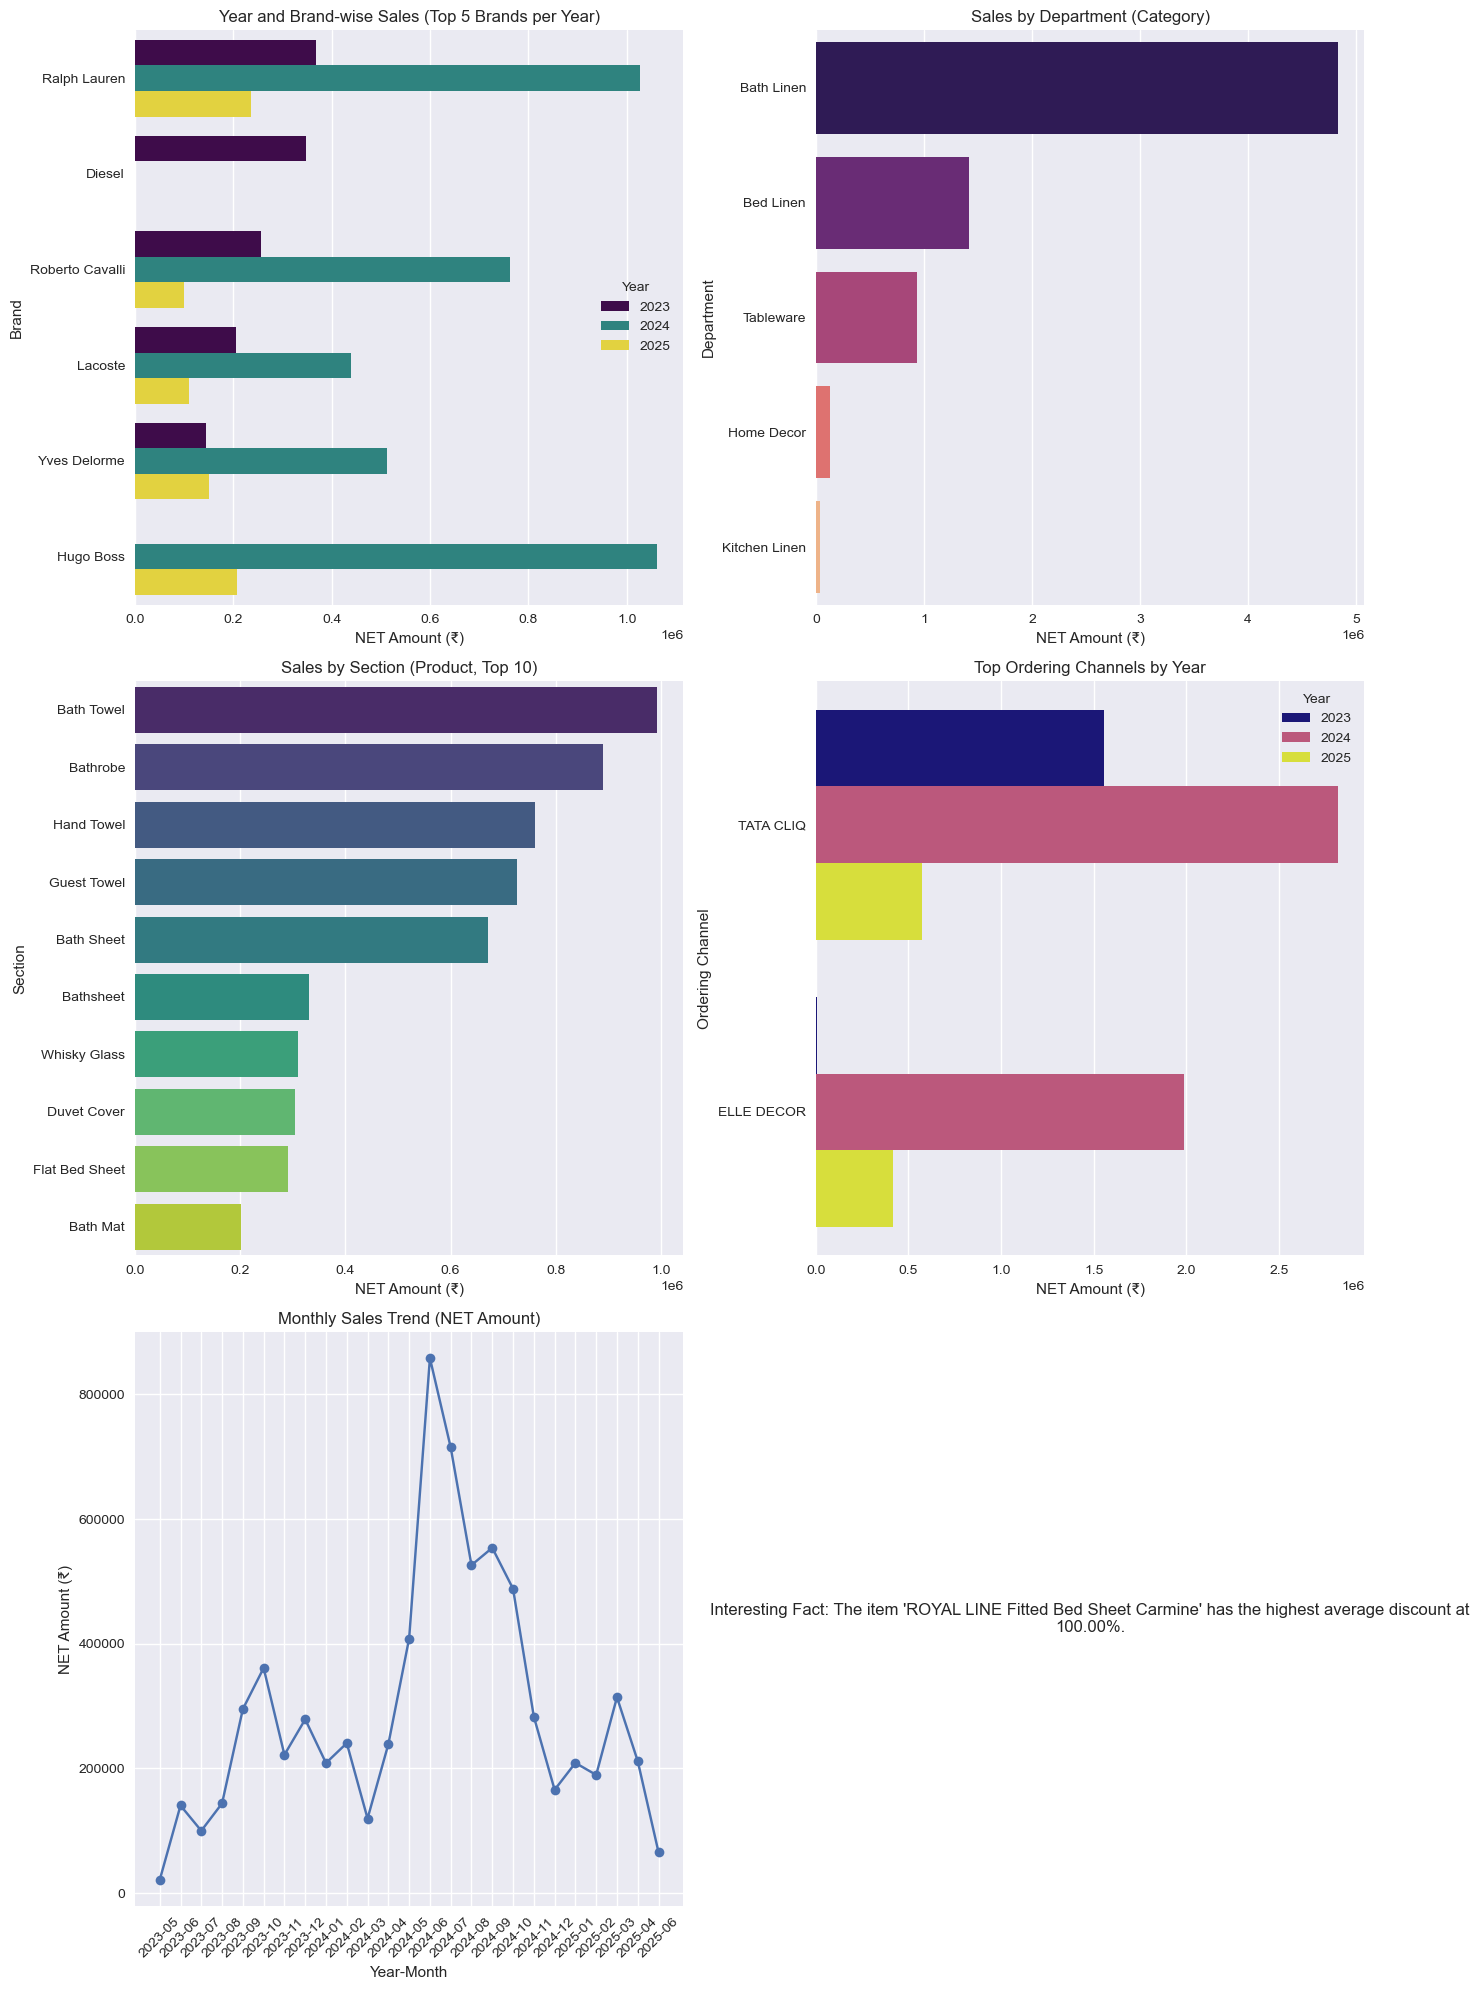

In [103]:
# Set plot style
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(15, 20))

# Plot 1: Year and Brand-wise Sales (Top 5 brands per year)
plt.subplot(3, 2, 1)
# Ensure year is treated as string or categorical for plotting hue
top_brands = query_results['year_brand_sales'].groupby('Year', group_keys=False).head(5)
sns.barplot(x='NET Amount', y='Brand', hue='Year', data=top_brands, palette='viridis')
plt.title('Year and Brand-wise Sales (Top 5 Brands per Year)')
plt.xlabel('NET Amount (₹)')
plt.ylabel('Brand')
plt.legend(title='Year')

# Plot 2: Department-wise Sales
plt.subplot(3, 2, 2)
sns.barplot(x='NET Amount', y='CATEGORY', data=query_results['department_sales'], palette='magma')
plt.title('Sales by Department (Category)')
plt.xlabel('NET Amount (₹)')
plt.ylabel('Department')

# Plot 3: Section-wise Sales
plt.subplot(3, 2, 3)
sns.barplot(x='NET Amount', y='Product', data=query_results['section_sales'].head(10), palette='viridis')
plt.title('Sales by Section (Product, Top 10)')
plt.xlabel('NET Amount (₹)')
plt.ylabel('Section')

# Plot 4: Top Ordering Channel Year-wise
plt.subplot(3, 2, 4)
top_channels = query_results['top_channel_year'].groupby('Year', group_keys=False).head(3)
sns.barplot(x='NET Amount', y='Ordering Channel', hue='Year', data=top_channels, palette='plasma')
plt.title('Top Ordering Channels by Year')
plt.xlabel('NET Amount (₹)')
plt.ylabel('Ordering Channel')
plt.legend(title='Year')

# Plot 5: Monthly Sales Trend
plt.subplot(3, 2, 5)
# Convert 'year_month' to string for plotting if not already
query_results['monthly_sales']['year_month'] = query_results['monthly_sales']['year_month'].astype(str)
plt.plot(query_results['monthly_sales']['year_month'], query_results['monthly_sales']['NET Amount'], marker='o')
plt.title('Monthly Sales Trend (NET Amount)')
plt.xlabel('Year-Month')
plt.ylabel('NET Amount (₹)')
plt.xticks(rotation=45)
plt.grid(True)

# Plot 6: Interesting Fact
plt.subplot(3, 2, 6)
# Ensure interesting_fact is a string variable from previous analysis cell
plt.text(0.5, 0.5, interesting_fact, ha='center', va='center', fontsize=12, wrap=True)
plt.axis('off')

plt.tight_layout()
plt.savefig('ecommerce_sales_analysis.png')
plt.show()

In [107]:
# Print Summary
print("E-Commerce Sales Analysis Summary")
print("----------------------------")
print("Total Sales (NET Amount): ₹", df_sales['NET Amount'].sum())
print("Total Quantity Sold:", df_sales['Qty'].sum())
print("Average Discount Percentage:", df_sales['discount_percentage'].mean())
print("\nTop 5 Departments (Categories) by Sales:")
print(query_results['department_sales'].nlargest(5, 'NET Amount'))
print("\nTop 5 Sections (Products) by Sales:")
print(query_results['section_sales'].nlargest(5, 'NET Amount'))
print("\nTop Ordering Channels by Year:")
print(query_results['top_channel_year'].groupby('Year').head(3))
print("\nReturn Rate by Category:")
print(query_results['return_rate'])
print("\nCOD vs Prepaid Sales:")
print(query_results['payment_type'])
print("\n", interesting_fact)

# Hidden Patterns and Recommendations to Increase Sales
print("\nHidden Patterns and Recommendations to Increase Sales:")
print("1. **Seasonal Trends**: Strong sales in June/July 2023 and April 2025 suggest seasonal demand (e.g., summer or pre-holiday). Launch targeted campaigns during these periods.")
print("2. **High-Performing Categories**: Bath Linen and Bed Linen lead sales. Expand inventory for high-value items like bath sheets and bed sheets.")
print("3. **Top Brands**: Ralph Lauren and Hugo Boss dominate. Strengthen partnerships and promote their premium products.")
print("4. **Discount Strategy**: Kitchen Linen has high discounts (e.g., EXTRASOFT Mitten Myrtille at ~95%). Optimize discounts to balance margins and stock clearance.")
print("5. **Channel Performance**: TATA CLIQ dominates in 2023, ELLE DECOR grows in 2025. Enhance listings and promotions on both platforms.")
print("6. **Returns Analysis**: Bath Linen has noticeable returns (e.g., row 1542). Investigate quality/sizing issues and improve product descriptions.")
print("7. **Payment Preferences**: COD vs Prepaid sales indicate customer preferences. Offer flexible payment options to boost conversions.")
print("8. **Upsell Opportunities**: Items with gift wrap or COD charges (e.g., row 1537) suggest premium purchases. Bundle high-margin accessories or offer personalized options.")

# Close MySQL connection
if 'conn' in locals() and conn.is_connected():
    conn.close()
    print("MySQL connection closed")

E-Commerce Sales Analysis Summary
----------------------------
Total Sales (NET Amount): ₹ 7358933
Total Quantity Sold: 1337
Average Discount Percentage: 8.47878195512511

Top 5 Departments (Categories) by Sales:
        CATEGORY  NET Amount
0     Bath Linen     4833618
1      Bed Linen     1420554
4      Tableware      934125
2     Home Decor      131792
3  Kitchen Linen       38844

Top 5 Sections (Products) by Sales:
        Product  NET Amount
4    Bath Towel      993043
5      Bathrobe      889905
27   Hand Towel      761303
26  Guest Towel      726536
2    Bath Sheet      671160

Top Ordering Channels by Year:
   Year Ordering Channel  NET Amount
1  2023        TATA CLIQ     1556631
0  2023       ELLE DECOR        5828
3  2024        TATA CLIQ     2819694
2  2024       ELLE DECOR     1987016
5  2025        TATA CLIQ      571183
4  2025       ELLE DECOR      418581

Return Rate by Category:
        CATEGORY  ReturnQty  SalesQty  ReturnRate
2  Kitchen Linen         -6        50  -1